In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import abc
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Generator, Optional
import time
import wandb

from dnadb.datasets import Greengenes, Silva
from dnadb import dna, fasta, sample, taxonomy

from deepdna.data.dataset import Dataset
from deepdna.nn.models import load_model
from deepdna.nn.models.custom_model import ModelWrapper, CustomModel
from deepdna.nn.models.dnabert import DnaBertModel, DnaBertPretrainModel, DnaBertEncoderModel
from deepdna.nn.models.taxonomy import NaiveTaxonomyClassificationModel
from deepdna.nn.models.utils import encapsulate_model
from deepdna.nn import layers, functional, utils
from deepdna.nn.data_generators import SequenceTaxonomyGenerator
from deepdna.nn.losses import SparseCategoricalCrossentropyWithIgnoreClass
from deepdna.nn.metrics import f1_score, SparseCategoricalAccuracyWithIgnoreClass

In [3]:
tfu.devices.select_gpu(1)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [4]:
api = wandb.Api()

In [5]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:latest").download()
pretrain_model = load_model(path)

wandb:   4 of 4 files downloaded.  


In [6]:
dnabert_weights = pretrain_model.get_weights()

## Dataset

In [7]:
silva = Dataset(Path("~/work/Datasets/Silva/0").expanduser())

In [8]:
train_fasta_db = sample.load_fasta(next(silva.fasta_dbs(Dataset.Split.Train)))
train_taxonomy_db = taxonomy.TaxonomyDb(next(silva.taxonomy_dbs(Dataset.Split.Train)))

test_fasta_db = sample.load_fasta(next(silva.fasta_dbs(Dataset.Split.Test)))
test_taxonomy_db = taxonomy.TaxonomyDb(next(silva.taxonomy_dbs(Dataset.Split.Test)))

In [9]:
hierarchy = taxonomy.TaxonomyHierarchy.from_dbs([train_taxonomy_db], depth=6)
hierarchy.tokenize("k__Eukaryota; p__Apicomplexa; c__Aconoidasida; o__Haemosporoidia; f__Haemosporoidia; g__Plasmodium")

array([   2,  102,  258,  652, 1177, 3709], dtype=int32)

In [10]:
hierarchy.tokenize("k__Eukaryota; p__", pad=True, include_missing=True)

array([3, 0, 0, 0, 0, 0], dtype=int32)

In [16]:
INCLUDE_MISSING = False

In [17]:
train_dataset = SequenceTaxonomyGenerator(
    [(train_fasta_db, train_taxonomy_db)],
    taxonomy_hierarchy=hierarchy,
    labels_as_dict=False,
    sequence_length=150,
    kmer=3,
    subsample_size=5,
    include_missing=INCLUDE_MISSING,
    batches_per_epoch=100,
    batch_size=256,
    rng=np.random.default_rng(0),
)

test_dataset = SequenceTaxonomyGenerator(
    [(test_fasta_db, test_taxonomy_db)],
    taxonomy_hierarchy=train_dataset.hierarchy,
    labels_as_dict=False,
    sequence_length=150,
    kmer=3,
    subsample_size=5,
    include_missing=INCLUDE_MISSING,
    batches_per_epoch=16,
    batch_size=256,
    rng=np.random.default_rng(1),
)

In [19]:
train_dataset_named = SequenceTaxonomyGenerator(
    [(train_fasta_db, train_taxonomy_db)],
    taxonomy_hierarchy=hierarchy,
    labels_as_dict=True,
    sequence_length=150,
    kmer=3,
    # subsample_size=5,
    include_missing=INCLUDE_MISSING,
    batches_per_epoch=100,
    batch_size=256,
    rng=np.random.default_rng(0),
)

test_dataset_named = SequenceTaxonomyGenerator(
    [(test_fasta_db, test_taxonomy_db)],
    taxonomy_hierarchy=train_dataset.hierarchy,
    labels_as_dict=True,
    sequence_length=150,
    kmer=3,
    # subsample_size=5,
    include_missing=INCLUDE_MISSING,
    batches_per_epoch=16,
    batch_size=256,
    rng=np.random.default_rng(1),
)

In [20]:
hierarchy.taxon_counts

(3, 203, 580, 1482, 2405, 8446)

In [25]:
x = pretrain_model.base.model.input
y = pretrain_model.base.model.output
y, _ = layers.SplitClassToken()(y)
encoder = tf.keras.Model(x, y)

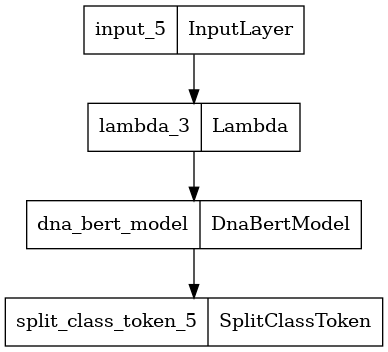

In [27]:
encoder = DnaBertEncoderModel(pretrain_model.base, 256)
tf.keras.utils.plot_model(encoder)

In [47]:
# @CustomObject
class TopDownConcatTaxonomyClassificationModel(NaiveTaxonomyClassificationModel):
    def build_model(self):
        x, y = encapsulate_model(self.base)
        outputs = [
            tf.keras.layers.Dense(
                self.hierarchy.taxon_counts[0] + int(self.include_missing),
                name=f"{taxonomy.RANKS[0].lower()}_projection")(y)
        ]
        for i, count in enumerate(self.hierarchy.taxon_counts[1:], start=1):
            # Use previous output to gate the next layer
            concat = tf.keras.layers.Concatenate()((y, outputs[-1]))
            output = tf.keras.layers.Dense(
                count + int(self.include_missing),
                name=f"{taxonomy.RANKS[i].lower()}_projection"
            )(concat)
            outputs.append(output)
        return tf.keras.Model(x, outputs)

In [51]:
TopDownConcatTaxonomyClassificationModel(encoder, hierarchy)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 148)]        0           []                               
                                                                                                  
 dna_bert_encoder_model_2 (DnaB  (None, 64)          1210496     ['input_11[0][0]']               
 ertEncoderModel)                                                                                 
                                                                                                  
 kingdom_projection (Dense)     (None, 4)            260         ['dna_bert_encoder_model_2[6][0]'
                                                                 ]                                
                                                                                           

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 148)]        0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 148)          0           ['input_5[0][0]']                
                                                                                                  
 dna_bert_model (DnaBertModel)  (None, 149, 64)      1210496     ['lambda_3[0][0]']               
                                                                                                  
 split_class_token_5 (SplitClas  ((None, 64),        0           ['dna_bert_model[4][0]']         
 sToken)                         (None, 148, 64))                                          

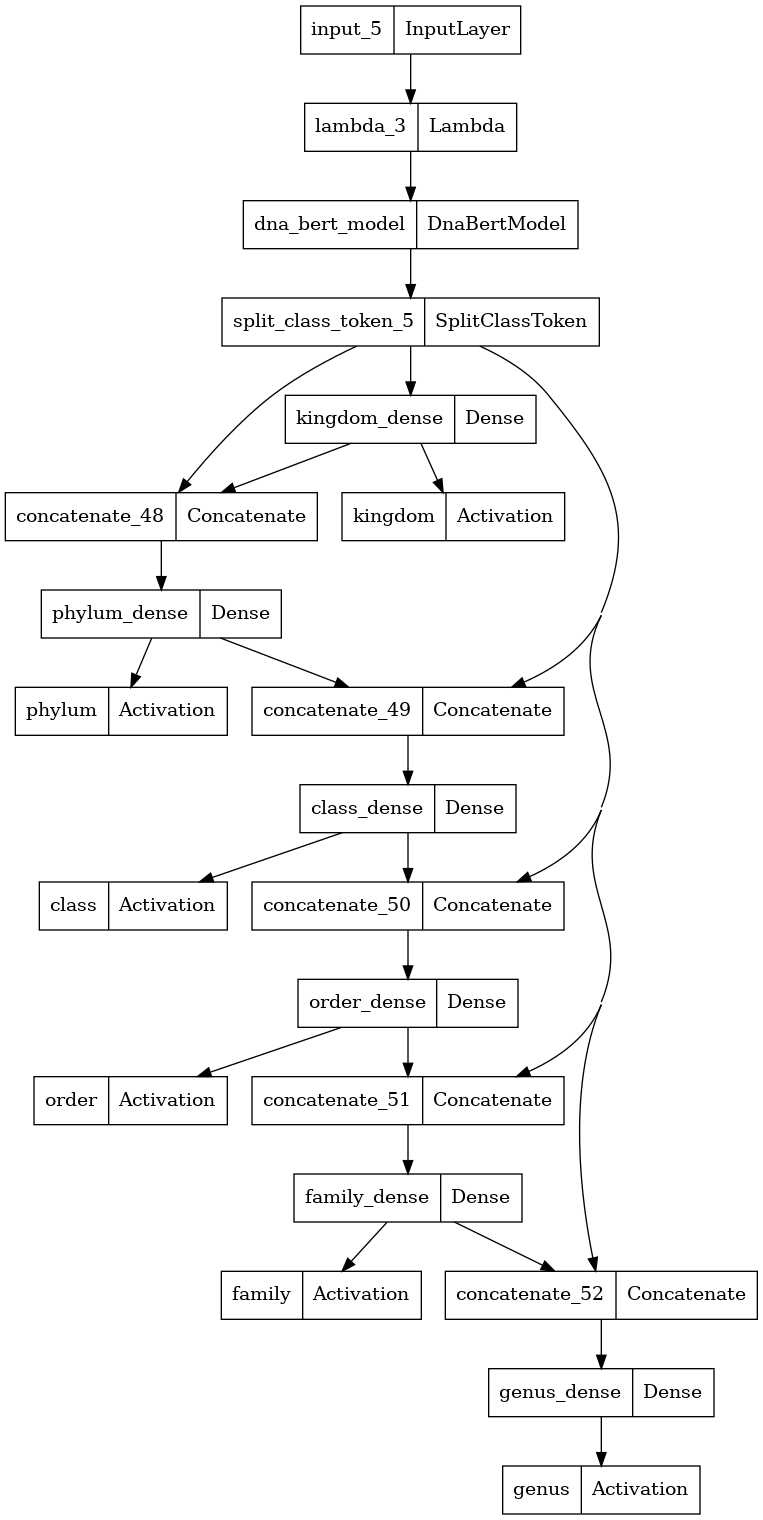

In [45]:
y, x = encoder.output, encoder.input
outputs = [tf.keras.layers.Dense(hierarchy.taxon_counts[0], name=f"{taxonomy.RANKS[0].lower()}_dense")(y)]
for i, count in enumerate(hierarchy.taxon_counts[1:], start=1):
    outputs.append(tf.keras.layers.Dense(count, name=f"{taxonomy.RANKS[i].lower()}_dense")(tf.keras.layers.Concatenate()((y, outputs[-1]))))
outputs = [tf.keras.layers.Activation("softmax", name=taxonomy.RANKS[i].lower())(o) for i, o in enumerate(outputs)]
model = tf.keras.Model(x, outputs)
model.summary()
tf.keras.utils.plot_model(model)
# hierarchy.taxon_counts

In [17]:
pretrain_model.set_weights(dnabert_weights)
# encoder = DnaBertEncoderModel(pretrain_model.base, chunk_size=256)
model = NaiveTaxonomyClassificationModel(encoder, hierarchy).model
model.compile(
    loss=SparseCategoricalCrossentropyWithIgnoreClass(ignore_class=-1),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    jit_compile=True
)

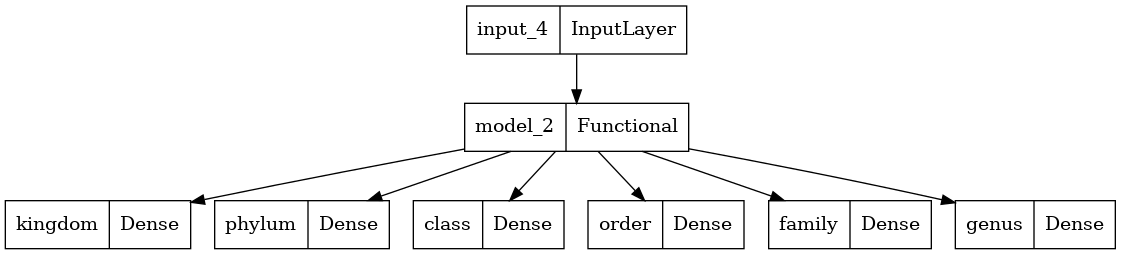

In [18]:
# model.plot(to_file="/tmp/model.png")
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(train_dataset, validation_data=test_dataset)

2023-06-15 14:05:06.205218: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. model_4/model_2/relative_transformer_block/dropout/dropout/random_uniform/RandomUniform


In [45]:
model.save("/tmp/test")

INFO:tensorflow:Assets written to: /tmp/test/assets


INFO:tensorflow:Assets written to: /tmp/test/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [46]:
model2 = load_model("/tmp/test", custom_objects={"NaiveTaxonomyClassificationModel": NaiveTaxonomyClassificationModel})

Initializing model
Initializing model
Initializing model


In [47]:
model2.evaluate(train_dataset)

100/100 [==============================] - 9s 83ms/step - loss: 36.0351 - kingdom_loss: 0.8525 - phylum_loss: 5.0746 - class_loss: 6.1432 - order_loss: 7.2318 - family_loss: 7.7430 - genus_loss: 8.9898 - kingdom_sparse_categorical_accuracy: 0.8911 - phylum_sparse_categorical_accuracy: 0.2519 - class_sparse_categorical_accuracy: 0.2245 - order_sparse_categorical_accuracy: 0.0711 - family_sparse_categorical_accuracy: 0.0434 - genus_sparse_categorical_accuracy: 0.0519


[36.03510284423828,
 0.8525350093841553,
 5.07463264465332,
 6.1432085037231445,
 7.231846332550049,
 7.743000030517578,
 8.989849090576172,
 0.8911328315734863,
 0.25187501311302185,
 0.22449219226837158,
 0.07113280892372131,
 0.043437499552965164,
 0.05191406235098839]

---

## Naive Model (Unnamed Layers)

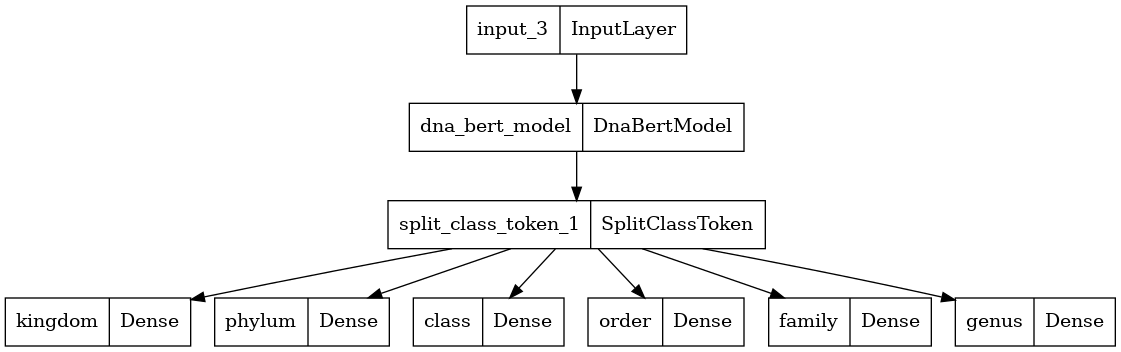

In [20]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
outputs = []
for i in range(hierarchy.depth):
    rank = taxonomy.RANKS[i]
    output = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + int(INCLUDE_MISSING), name=rank.lower())(y)
    outputs.append(output)
model = tf.keras.Model(x, outputs)
model.compile(
    loss=SparseCategoricalCrossentropyWithIgnoreClass(from_logits=True, ignore_class=(None if INCLUDE_MISSING else -1)),
    metrics=[
        SparseCategoricalAccuracyWithIgnoreClass(ignore_class=(None if INCLUDE_MISSING else -1)),
    ],
    optimizer=tf.keras.optimizers.Adam(1e-4),
    run_eagerly=True
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 148)]        0           []                               
                                                                                                  
 dna_bert_model (DnaBertModel)  (None, 149, 64)      1210496     ['input_3[0][0]']                
                                                                                                  
 split_class_token_1 (SplitClas  ((None, 64),        0           ['dna_bert_model[1][0]']         
 sToken)                         (None, 148, 64))                                                 
                                                                                                  
 kingdom (Dense)                (None, 4)            260         ['split_class_token_1[0][0]

In [22]:
history_naive_unnamed = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

Epoch 1/100



KeyboardInterrupt



In [ ]:
for rank in taxonomy.RANKS[:hierarchy.depth]:
    values = history_naive_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.plot(values, label=f"{rank} ({values[-1]:.2%})")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

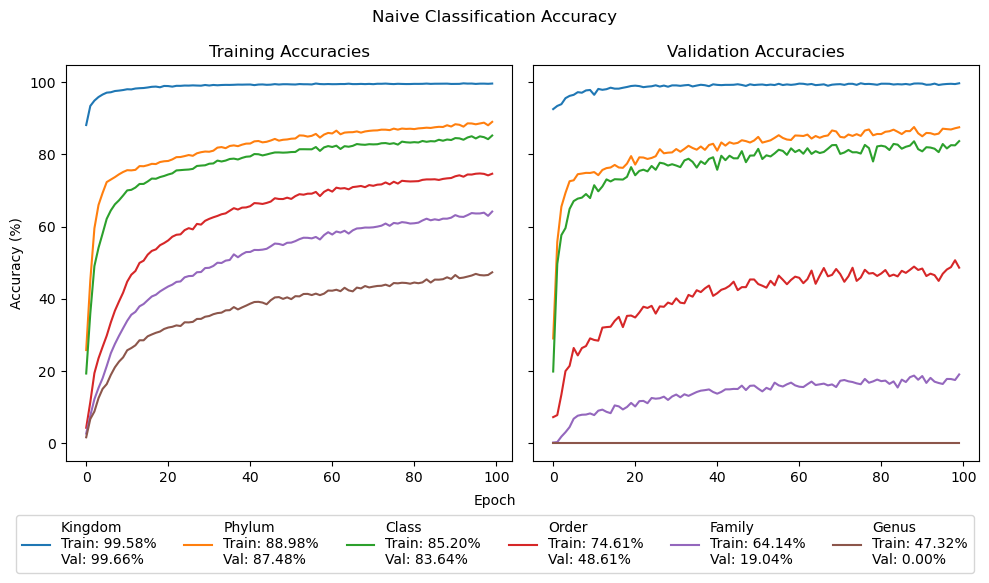

In [27]:
# plt.figure(figsize=(10, 4))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i, rank in enumerate(taxonomy.RANKS[:hierarchy.depth]):
    train_values = history_naive_unnamed.history[f"{rank.lower()}_sparse_categorical_accuracy"]
    val_values = history_naive_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.subplot(1, 2, 1)
    plt.plot(100.0*np.array(train_values), label=f"{rank}\nTrain: {train_values[-1]:.2%}\nVal: {val_values[-1]:.2%}")
    plt.subplot(1, 2, 2)
    plt.plot(100.0*np.array(val_values))
axs[0].set_title("Training Accuracies")
axs[1].set_title("Validation Accuracies")
axs[0].set_ylabel("Accuracy (%)")
handles, labels = axs[0].get_legend_handles_labels()
fig.suptitle("Naive Classification Accuracy")
fig.text(0.5, -0.01, 'Epoch', ha='center')
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.16, 0.0, 0.0), ncol=6)
plt.tight_layout()
plt.show()

---

### Naive Model (Name Layers)

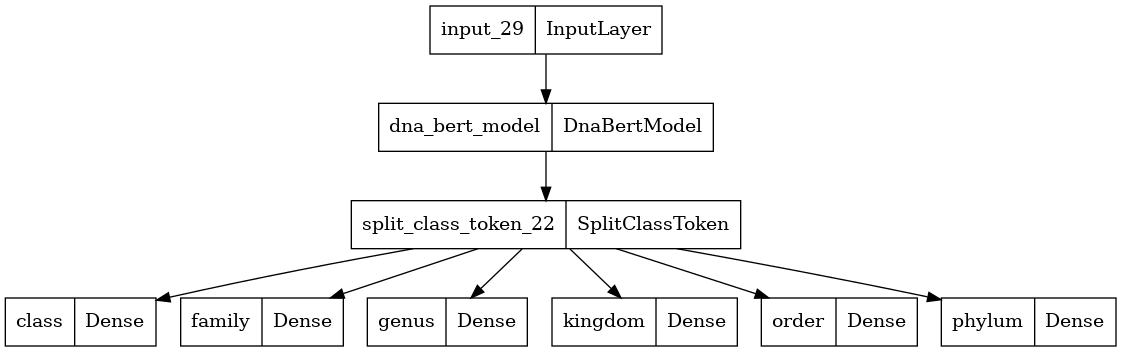

In [95]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
outputs = {}
for i in range(hierarchy.depth):
    rank = taxonomy.RANKS[i]
    output = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + 1, name=rank.lower())(y)
    outputs[rank.lower()] = output
model = tf.keras.Model(x, outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [97]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 148)]        0           []                               
                                                                                                  
 dna_bert_model (DnaBertModel)  (None, 149, 64)      1210496     ['input_29[0][0]']               
                                                                                                  
 split_class_token_22 (SplitCla  ((None, 64),        0           ['dna_bert_model[22][0]']        
 ssToken)                        (None, 148, 64))                                                 
                                                                                                  
 class (Dense)                  (None, 581)          37765       ['split_class_token_22[0][

In [84]:
history_naive_named = model.fit(train_dataset_named, epochs=10)

Epoch 1/10
100/100 [==============================] - 26s 213ms/step - loss: 29.0907 - class_loss: 4.3837 - family_loss: 6.7125 - genus_loss: 7.8991 - kingdom_loss: 0.4970 - order_loss: 6.0731 - phylum_loss: 3.5254 - class_sparse_categorical_accuracy: 0.1689 - family_sparse_categorical_accuracy: 0.0257 - genus_sparse_categorical_accuracy: 0.0066 - kingdom_sparse_categorical_accuracy: 0.8786 - order_sparse_categorical_accuracy: 0.0413 - phylum_sparse_categorical_accuracy: 0.2355
Epoch 2/10
100/100 [==============================] - 21s 214ms/step - loss: 21.6121 - class_loss: 3.0940 - family_loss: 5.2559 - genus_loss: 6.1162 - kingdom_loss: 0.2506 - order_loss: 4.4372 - phylum_loss: 2.4583 - class_sparse_categorical_accuracy: 0.2519 - family_sparse_categorical_accuracy: 0.0531 - genus_sparse_categorical_accuracy: 0.0523 - kingdom_sparse_categorical_accuracy: 0.9352 - order_sparse_categorical_accuracy: 0.0815 - phylum_sparse_categorical_accuracy: 0.3520
Epoch 3/10
100/100 [==============

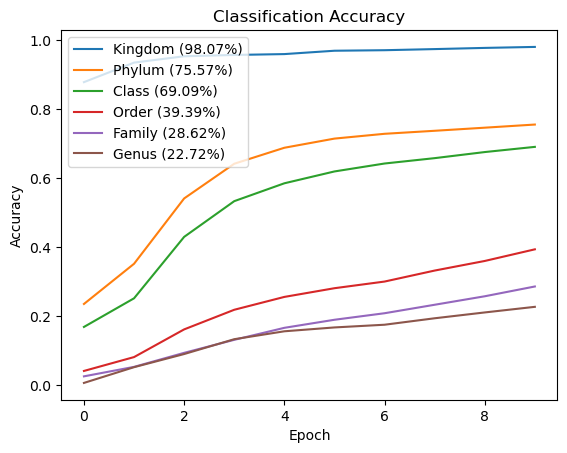

In [85]:
for rank in taxonomy.RANKS[:hierarchy.depth]:
    values = history_naive_named.history[f"{rank.lower()}_sparse_categorical_accuracy"]
    plt.plot(values, label=f"{rank} ({values[-1]:.2%})")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

---

### BERTax Unnamed

In [26]:
class AbstractTaxonomyClassifier(tf.keras.Model):
    def __init__(
        self,
        hierarchy: taxonomy.TaxonomyHierarchy,
        include_missing: bool = True,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.hierarchy = hierarchy
        self.include_missing = include_missing

    def get_config(self, config):
        return super().get_config() | {
            "hierarchy": self.hierarchy.serialize().decode(),
            "include_missing": self.include_missing,
        }

    @classmethod
    def from_config(cls, config):
        config["hierarchy"] = taxonomy.TaxonomyHierarchy.deserialize(config["hierarchy"].encode())
        return super().from_config(config)

    def __call__(self, *args, **kwargs):
        outputs = super().__call__(*args, **kwargs)
        outputs = [
            tf.keras.layers.Activation("softmax", name=rank)(output)
            for rank, output in zip(map(str.lower, taxonomy.RANKS), outputs)
        ]
        # if self.use_named_outputs:
        #     outputs = dict(zip(map(str.lower, taxonomy.RANKS), outputs))
        return outputs

In [27]:
class BertaxClassification(AbstractTaxonomyClassifier):
    def __init__(
        self,
        hierarchy: taxonomy.TaxonomyHierarchy,
        include_missing: bool = True,
        **kwargs
    ):
        super().__init__(hierarchy, include_missing, **kwargs)
        self.dense_layers = [
            tf.keras.layers.Dense(c + int(self.include_missing), activation="softmax", name=name.lower())
            for name, c in zip(taxonomy.RANKS, self.hierarchy.taxon_counts)]

    def call(self, inputs, training=None):
        prev = inputs
        out_layer = []
        for dense in self.dense_layers:
            out = dense(prev)
            out_layer.append(out)
            in_help = out_layer.copy()
            in_help.append(prev)
            prev = tf.keras.layers.Concatenate()(in_help)
        return tuple(out_layer)

In [84]:
class BertaxTaxonomyClassificationModel(NaiveTaxonomyClassificationModel):
    def build_model(self):
        x, y = encapsulate_model(self.base)
        prev = y
        outputs = []
        for i in range(hierarchy.depth):
            rank = taxonomy.RANKS[i].lower()
            out = tf.keras.layers.Dense(
                hierarchy.taxon_counts[i] + int(self.include_missing),
                name=rank)(prev)
            outputs.append(out)
            in_help = outputs.copy()
            in_help.append(prev)
            prev = tf.keras.layers.Concatenate()(in_help)
        return tf.keras.Model(x, outputs)

Initializing model
Initializing model


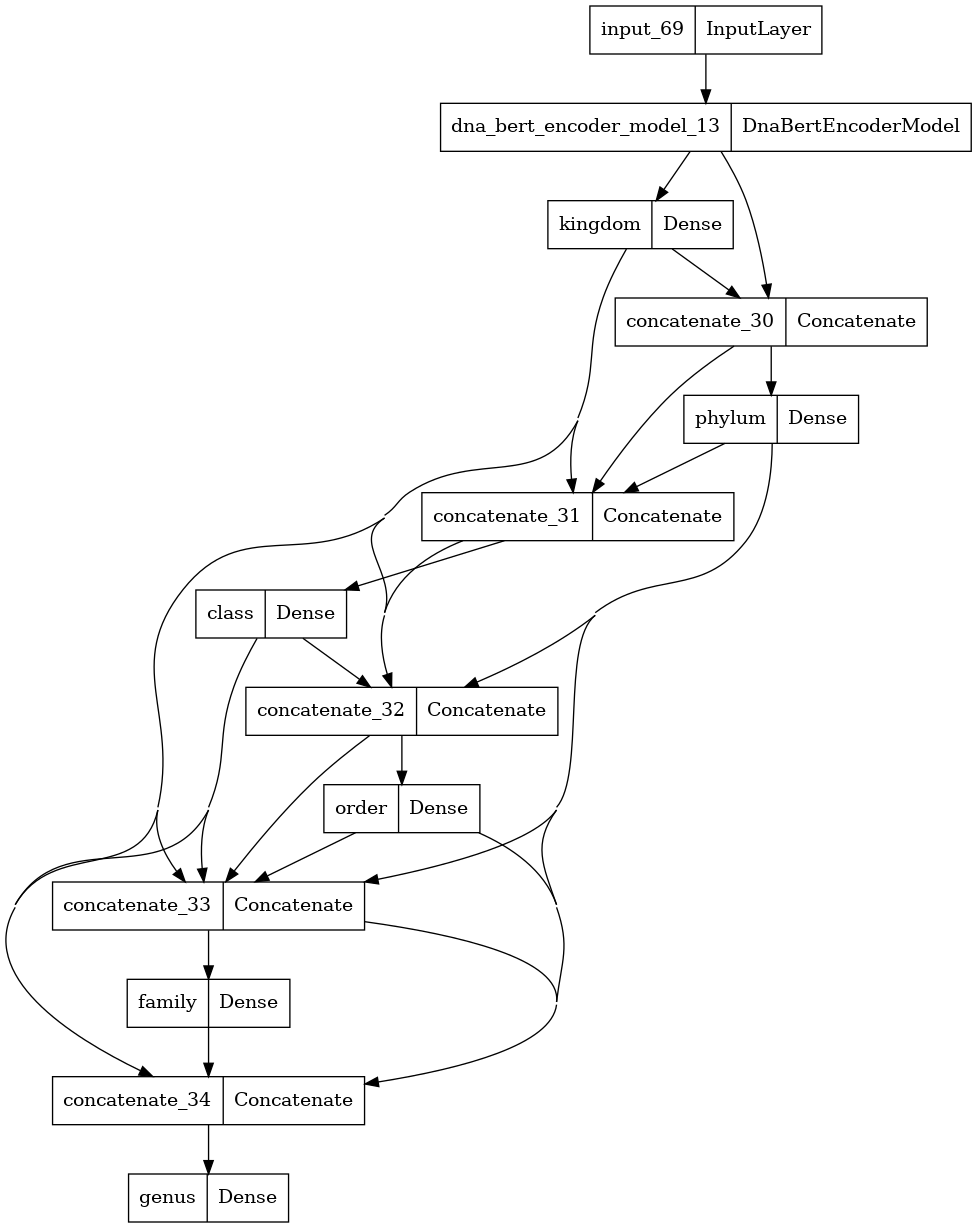

In [90]:
pretrain_model.set_weights(dnabert_weights)
# y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
# y = pretrain_model.base(y)
# y, _ = layers.SplitClassToken()(y)
encoder = DnaBertEncoderModel(pretrain_model.base, chunk_size=256)
model = BertaxTaxonomyClassificationModel(encoder, hierarchy)
model.compile()
model.plot()

In [91]:
model.summary()

Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 148)]        0           []                               
                                                                                                  
 dna_bert_encoder_model_13 (Dna  (None, 64)          1210496     ['input_69[0][0]']               
 BertEncoderModel)                                                                                
                                                                                                  
 kingdom (Dense)                (None, 4)            260         ['dna_bert_encoder_model_13[2][0]
                                                                 ']                               
                                                                                           

In [93]:
history_bertax_unnamed = model.fit(train_dataset_named, validation_data=test_dataset_named, epochs=100)

Epoch 1/100
100/100 [==============================] - 31s 248ms/step - loss: 97.1881 - kingdom_loss: 1.4123 - phylum_loss: 5.4399 - class_loss: 5.9337 - order_loss: 7.6838 - family_loss: 14.6446 - genus_loss: 62.0737 - kingdom_sparse_categorical_accuracy: 0.7569 - phylum_sparse_categorical_accuracy: 0.1188 - class_sparse_categorical_accuracy: 0.1264 - order_sparse_categorical_accuracy: 0.0500 - family_sparse_categorical_accuracy: 0.0283 - genus_sparse_categorical_accuracy: 0.0150 - val_loss: 44.7037 - val_kingdom_loss: 0.5843 - val_phylum_loss: 4.2639 - val_class_loss: 3.9997 - val_order_loss: 5.7913 - val_family_loss: 8.1445 - val_genus_loss: 21.9200 - val_kingdom_sparse_categorical_accuracy: 0.8945 - val_phylum_sparse_categorical_accuracy: 0.1956 - val_class_sparse_categorical_accuracy: 0.1565 - val_order_sparse_categorical_accuracy: 0.0422 - val_family_sparse_categorical_accuracy: 0.0000e+00 - val_genus_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==================


KeyboardInterrupt



In [96]:
model.save("/tmp/test")

INFO:tensorflow:Assets written to: /tmp/test/assets


INFO:tensorflow:Assets written to: /tmp/test/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [97]:
model2 = load_model("/tmp/test", custom_objects={"BertaxTaxonomyClassificationModel": BertaxTaxonomyClassificationModel})

Initializing model
Initializing model
Initializing model


In [98]:
model2.evaluate(train_dataset)

100/100 [==============================] - 9s 84ms/step - loss: 27.8871 - kingdom_loss: 0.3601 - phylum_loss: 3.5824 - class_loss: 4.1705 - order_loss: 5.4182 - family_loss: 5.9413 - genus_loss: 8.4145 - kingdom_sparse_categorical_accuracy: 0.9321 - phylum_sparse_categorical_accuracy: 0.2856 - class_sparse_categorical_accuracy: 0.2344 - order_sparse_categorical_accuracy: 0.0977 - family_sparse_categorical_accuracy: 0.0667 - genus_sparse_categorical_accuracy: 0.0373


[27.887067794799805,
 0.3601182997226715,
 3.582442045211792,
 4.170529365539551,
 5.418212890625,
 5.9412841796875,
 8.414477348327637,
 0.9321093559265137,
 0.28562501072883606,
 0.23441405594348907,
 0.09765625,
 0.06671874970197678,
 0.03734375163912773]

In [ ]:
for rank in taxonomy.RANKS[:hierarchy.depth]:
    values = history_bertax_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.plot(values, label=f"{rank} ({values[-1]:.2%})")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

NameError: name 'history_bertax_unnamed' is not defined

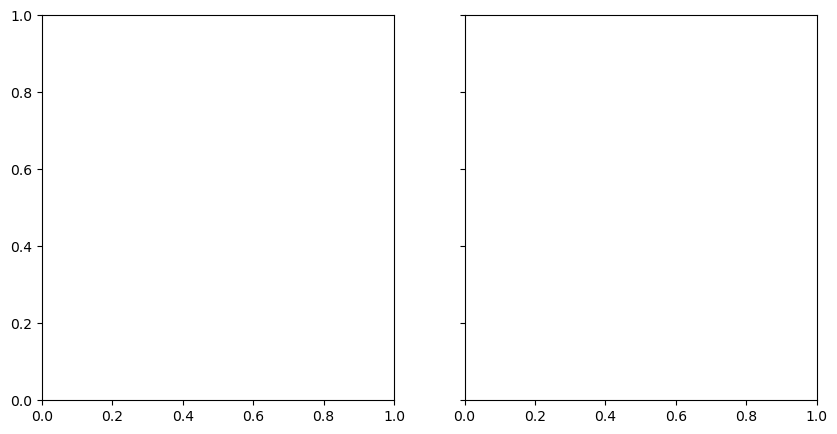

In [28]:
# plt.figure(figsize=(10, 4))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i, rank in enumerate(taxonomy.RANKS[:hierarchy.depth]):
    train_values = history_bertax_unnamed.history[f"{rank.lower()}_sparse_categorical_accuracy"]
    val_values = history_bertax_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.subplot(1, 2, 1)
    plt.plot(100.0*np.array(train_values), label=f"{rank}\nTrain: {train_values[-1]:.2%}\nVal: {val_values[-1]:.2%}")
    plt.subplot(1, 2, 2)
    plt.plot(100.0*np.array(val_values))
axs[0].set_title("Training Accuracies")
axs[1].set_title("Validation Accuracies")
axs[0].set_ylabel("Accuracy (%)")
handles, labels = axs[0].get_legend_handles_labels()
fig.suptitle("Naive Classification Accuracy")
fig.text(0.5, -0.01, 'Epoch', ha='center')
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.16, 0.0, 0.0), ncol=6)
plt.tight_layout()
plt.show()

---

### Ours Unnamed

In [75]:
class TopDownTaxonomyClassificationModel(NaiveTaxonomyClassificationModel):
    def build_model(self):
        taxon_counts_by_level = []
        for i, taxons in enumerate(self.hierarchy.taxons[:-1]):
            taxon_counts_by_level.append([1])
            for taxon in taxons:
                taxon_counts_by_level[i].append(len(taxon.children))
        taxon_counts_by_level[0]

        x, y = encapsulate_model(self.base)
        outputs = [tf.keras.layers.Dense(hierarchy.taxon_counts[0] + 1, name=f"{taxonomy.RANKS[0].lower()}")(y)]
        for i, taxon_counts in enumerate(taxon_counts_by_level, start=1):
            # Use previous output to gate the next layer
            gate_indices = [j for j, count in enumerate(taxon_counts) for _ in range(count)]
            gate = tf.gather(outputs[-1], gate_indices, axis=-1)
            gated_output = tf.keras.layers.Dense(
                hierarchy.taxon_counts[i] + 1,
                name=f"{taxonomy.RANKS[i].lower()}_projection"
            )(y)
            outputs.append(tf.keras.layers.Add(name=f"{taxonomy.RANKS[i].lower()}")([gated_output, gate]))
        return tf.keras.Model(x, outputs)



Initializing model
Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 148)]        0           []                               
                                                                                                  
 dna_bert_encoder_model_7 (DnaB  (None, 64)          1210496     ['input_55[0][0]']               
 ertEncoderModel)                                                                                 
                                                                                                  
 kingdom (Dense)                (None, 4)            260         ['dna_bert_encoder_model_7[25][0]
                                                                 ']                               
                                                                        

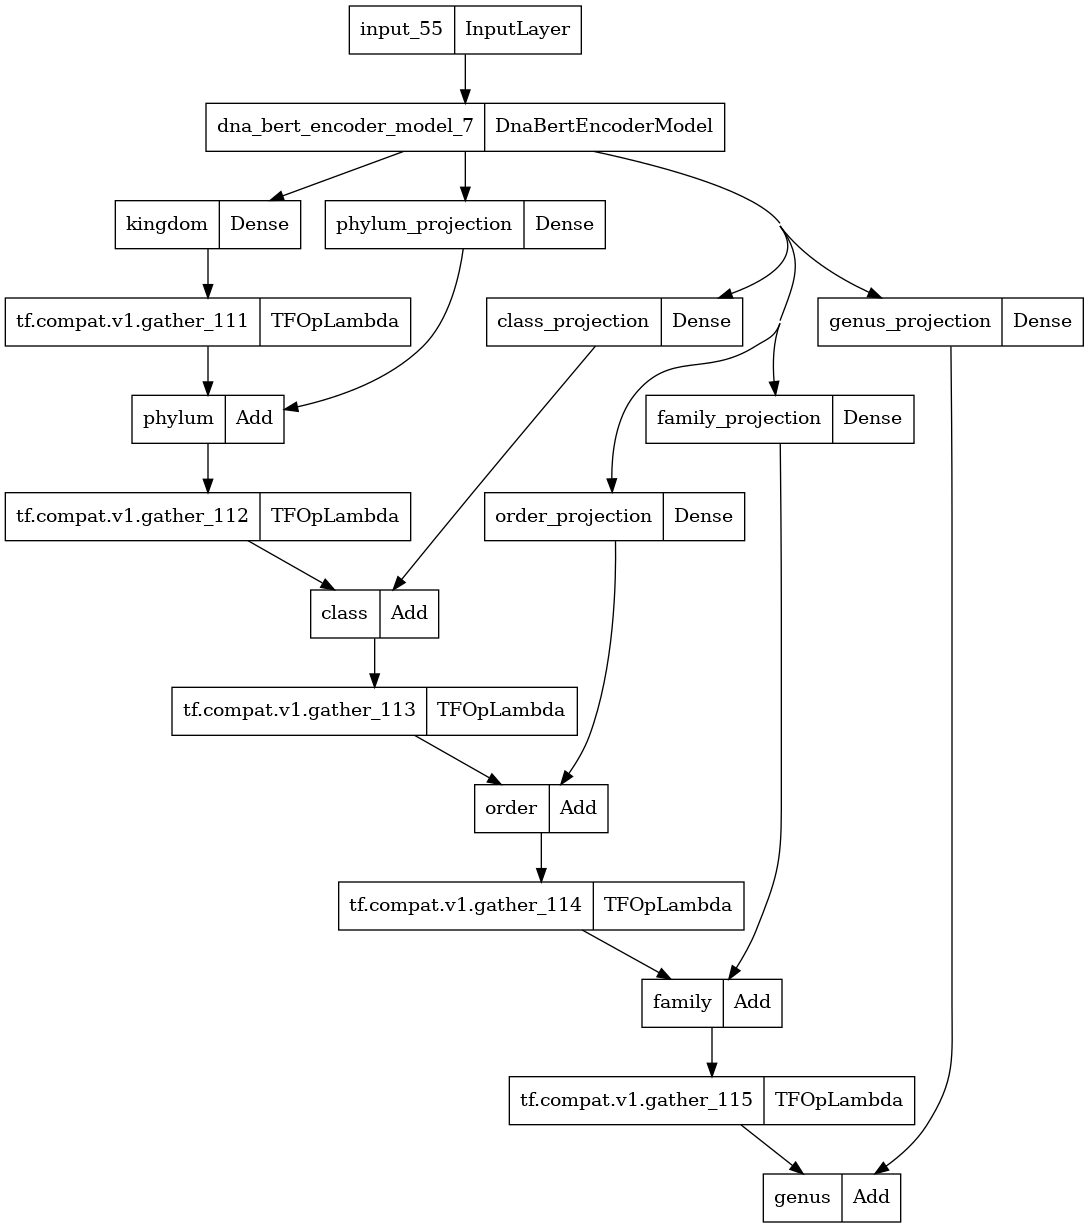

In [79]:
model = TopDownTaxonomyClassificationModel(encoder, hierarchy)
model.compile()
model.summary()
model.plot()

In [80]:
history_ours_unnamed = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

Epoch 1/100
100/100 [==============================] - 30s 238ms/step - loss: 37.9173 - kingdom_loss: 1.7215 - phylum_loss: 5.2209 - class_loss: 6.0529 - order_loss: 7.5170 - family_loss: 8.2945 - genus_loss: 9.1105 - kingdom_sparse_categorical_accuracy: 0.7109 - phylum_sparse_categorical_accuracy: 0.1959 - class_sparse_categorical_accuracy: 0.1119 - order_sparse_categorical_accuracy: 0.0509 - family_sparse_categorical_accuracy: 0.0323 - genus_sparse_categorical_accuracy: 0.0346 - val_loss: 23.9733 - val_kingdom_loss: 0.5321 - val_phylum_loss: 3.1264 - val_class_loss: 3.5704 - val_order_loss: 5.7483 - val_family_loss: 7.4816 - val_genus_loss: 3.5146 - val_kingdom_sparse_categorical_accuracy: 0.8853 - val_phylum_sparse_categorical_accuracy: 0.3916 - val_class_sparse_categorical_accuracy: 0.1765 - val_order_sparse_categorical_accuracy: 0.0469 - val_family_sparse_categorical_accuracy: 0.0000e+00 - val_genus_sparse_categorical_accuracy: 0.0122
Epoch 2/100
100/100 [=========================


KeyboardInterrupt



In [81]:
model.save("/tmp/test")

INFO:tensorflow:Assets written to: /tmp/test/assets


INFO:tensorflow:Assets written to: /tmp/test/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [82]:
model2 = load_model("/tmp/test", custom_objects={"TopDownTaxonomyClassificationModel": TopDownTaxonomyClassificationModel})

Initializing model
Initializing model
Initializing model


In [83]:
model2.evaluate(train_dataset)

 46/100 [============>.................] - ETA: 4s - loss: 13.0727 - kingdom_loss: 0.0540 - phylum_loss: 1.1971 - class_loss: 1.5597 - order_loss: 2.4182 - family_loss: 3.3082 - genus_loss: 4.5354 - kingdom_sparse_categorical_accuracy: 0.9864 - phylum_sparse_categorical_accuracy: 0.7306 - class_sparse_categorical_accuracy: 0.6841 - order_sparse_categorical_accuracy: 0.5186 - family_sparse_categorical_accuracy: 0.3714 - genus_sparse_categorical_accuracy: 0.2673


KeyboardInterrupt



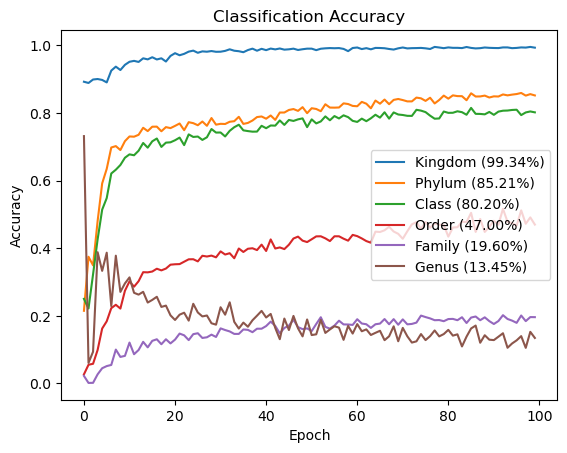

In [193]:
for rank in taxonomy.RANKS[:hierarchy.depth]:
    values = history_ours_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.plot(values, label=f"{rank} ({values[-1]:.2%})")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

---

In [ ]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
outputs = [tf.keras.layers.Dense(hierarchy.taxon_counts[0] + 1)(y)]
for i, taxon_counts in enumerate(taxon_counts_by_level, start=1):
    # Use previous output to gate the next layer
    gate_indices = [j for j, count in enumerate(taxon_counts) for _ in range(count)]
    gate = tf.gather(outputs[-1], gate_indices, axis=-1)
    gated_output = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + 1)(y)
    outputs.append(tf.keras.layers.Add()([gated_output, gate]))
outputs = [tf.keras.layers.Activation("softmax", name=rank.lower())(output) for rank, output in zip(taxonomy.RANKS, outputs)]
model = tf.keras.Model(x, outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [38]:
from typing import TypedDict

TaxonomyOutputDict = TypedDict(
    "TaxonomyOutputDict",
    {
        "kingdom": tf.Tensor,
        "phylum": tf.Tensor,
        "class": tf.Tensor,
        "order": tf.Tensor,
        "family": tf.Tensor,
        "genus": tf.Tensor,
        "species": tf.Tensor
    },
    total=False)

class TaxonomyBlock(layers.TypedLayer[[tf.Tensor], TaxonomyOutputDict]):
    @classmethod
    def from_hierarchy(cls, hierarchy: taxonomy.TaxonomyHierarchy):
        taxon_counts_by_level = tuple(
            tuple(len(t.children) for t in taxons) for taxons in hierarchy.taxons
        )
        return cls(taxon_counts_by_level)

    def __init__(
        self,
        taxon_counts_by_level: tuple[tuple[int, ...], ...],
        include_missing: bool = True,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.taxon_counts_by_level = taxon_counts_by_level
        self.include_missing = include_missing
        self.dense_layers = [
            tf.keras.layers.Dense(len(taxon_counts) + int(self.include_missing), name=name)
            for name, taxon_counts in zip(taxonomy.RANKS, self.taxon_counts_by_level)]

    def call(self, inputs: tf.Tensor) -> dict[str, tf.Tensor]:
        """
        Outputs
        """
        prev = inputs
        out_layer = []
        for dense in self.dense_layers:
            out = dense(prev)
            out_layer.append(out)
            in_help = out_layer.copy()
            in_help.append(prev)
            prev = tf.concat(in_help, axis=1)
        # return { name.lower(): output for name, output in zip(taxonomy.RANKS, out_layer) }
        return tuple(out_layer)

    def compute_output_shape(self, input_shape):
        return tuple(
            (input_shape[:-1], len(taxon_map))
            for taxon_map in self.hierarchy.taxon_maps[:self.depth])

    def get_config(self):
        return super().get_config() | {
            "taxon_counts_by_level": self.taxon_counts_by_level
        }

class TaxonomyHierarchyBlock(layers.TypedLayer[[tf.Tensor], TaxonomyOutputDict]):
    @classmethod
    def from_hierarchy(cls, hierarchy: taxonomy.TaxonomyHierarchy):
        taxon_counts_by_level = tuple(
            tuple(len(t.children) for t in taxons) for taxons in hierarchy.taxons
        )
        return cls(taxon_counts_by_level)

    def __init__(self, taxon_counts_by_level: tuple[tuple[int, ...], ...], **kwargs):
        super().__init__(**kwargs)
        self.taxon_counts_by_level = taxon_counts_by_level
        self.dense_layers = [
            tf.keras.layers.Dense(len(taxon_counts), name=name)
            for name, taxon_counts in zip(taxonomy.RANKS, self.taxon_counts_by_level)]

    def call(self, inputs: tf.Tensor) -> dict[str, tf.Tensor]:
        """
        Outputs
        """
        outputs = [self.dense_layers[0](inputs)]
        for dense, taxon_counts in zip(self.dense_layers[1:], self.taxon_counts_by_level):
            # Use previous output to gate the next layer
            gate_indices = [0] + [j for j, count in enumerate(taxon_counts, start=1) for _ in range(count)]
            gate = tf.gather(outputs[-1], gate_indices, axis=-1)
            outputs.append(dense(inputs) + gate)
        # outputs = map(tf.nn.softmax, outputs)
        # return { name.lower(): output for name, output in zip(taxonomy.TAXON_LEVEL_NAMES, outputs) }
        return tuple(outputs)

    def compute_output_shape(self, input_shape):
        return tuple(
            (input_shape[:-1], len(taxon_map))
            for taxon_map in self.hierarchy.taxon_maps[:self.depth])

    def get_config(self):
        return super().get_config() | {
            "taxon_counts_by_level": self.taxon_counts_by_level
        }

In [39]:
y = x = tf.keras.layers.Input((16,))
y = TaxonomyBlock.from_hierarchy(hierarchy)(y)
model = tf.keras.Model(x, y)

In [49]:
def flatten_and_mask(y_true, y_pred):
    # Flatten to make computation easier
    y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
    indices = tf.where(tf.reshape(y_true, tf.shape(y_true)[:1]) != -1)
    masked_y_true = tf.gather_nd(y_true, indices)
    masked_y_pred = tf.gather_nd(y_pred, indices)
    return masked_y_true, masked_y_pred

def MaskedSparseCategoricalCrossentropy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.losses.sparse_categorical_crossentropy(masked_y_true, masked_y_pred)

def MaskedSparseCategoricalAccuracy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.metrics.sparse_categorical_accuracy(masked_y_true, masked_y_pred)

class DnaBertTaxonomyModel(tf.keras.models.Model):
    def __init__(self, base: DnaBertModel, hierarchy: taxonomy.TaxonomyHierarchy, **kwargs):
        super().__init__(**kwargs)
        self.base = base
        self.hierarchy = hierarchy
        self.hierarchy_block = TaxonomyBlock.from_hierarchy(hierarchy)
        self.model = self.build_model()

    def build_model(self):
        x = self.base.input
        y = self.base(x)
        y, _ = layers.SplitClassToken()(y)
        y = self.hierarchy_block(y)
        return tf.keras.Model(x, y)

    def call(self, inputs):
        return self.model(inputs)

    def compute_output_shpe(self, input_shape):
        return self.model.compute_output_shape(input_shape)

    def get_config(self):
        return super().get_config() | {
            "base": self.base,
            "hierarchy": self.hierarchy.serialize().decode()
        }

    @classmethod
    def from_config(cls, config):
        config["hierarchy"] = taxonomy.TaxonomyHierarchy.deserialize(config["hierarchy"])
        return super().from_config(config)

In [52]:
model = DnaBertTaxonomyModel(pretrain_model, hierarchy)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [59]:
model.fit(train_dataset)

100/100 [==============================] - 21s 210ms/step - loss: 11.6948 - output_1_loss: 1.3863 - output_2_loss: 10.3085 - output_1_sparse_categorical_accuracy: 0.0202 - output_2_sparse_categorical_accuracy: 0.0026


In [177]:
def flatten_and_mask(y_true, y_pred):
    # Flatten to make computation easier
    y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
    indices = tf.where(tf.reshape(y_true, tf.shape(y_true)[:1]) != -1)
    masked_y_true = tf.gather_nd(y_true, indices)
    masked_y_pred = tf.gather_nd(y_pred, indices)
    return masked_y_true, masked_y_pred

def MaskedSparseCategoricalCrossentropy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.losses.sparse_categorical_crossentropy(masked_y_true, masked_y_pred)

def MaskedSparseCategoricalAccuracy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.metrics.sparse_categorical_accuracy(masked_y_true, masked_y_pred)

# def taxon_accuracy(y_true, y_pred):
#     # Flatten to make computation easier
#     y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
#     y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
#     correct = y_true == tf.argmax(y_pred, axis=-1)

#     # Mark masked elements as correct
#     mask_indices = tf.where(y_true == -1)
#     ones = tf.ones((tf.shape(mask_indices)[0],), dtype=tf.bool)
#     tf.tensor_scatter_nd_update(correct, mask_indices, ones)

#     return tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

In [181]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:latest").download()
pretrain_model = load_model(path)

model = DnaBertTaxonomyModel(pretrain_model.base, hierarchy)
model.model.compile(
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="kingdom_loss"),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="phylum_loss"),
    ],
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="kingdom_accuracy"),
        tf.keras.metrics.SparseCategoricalAccuracy(name="phylum_accuracy"),
    ],
    run_eagerly=False
)

wandb:   4 of 4 files downloaded.  


In [182]:
model.model(train_dataset[0][0])

(<tf.Tensor: shape=(256, 4), dtype=float32, numpy=
 array([[ 2.6379766 , -1.4894629 ,  0.3488425 ,  2.3652253 ],
        [ 0.99988204, -0.76885855, -0.45216867,  1.0107617 ],
        [ 1.1330127 ,  0.60395414,  2.3624098 , -1.3448695 ],
        ...,
        [ 1.5164968 , -0.10810965, -2.0917604 ,  0.5325261 ],
        [ 0.22892606, -1.1527599 , -2.0567613 ,  1.2639489 ],
        [ 2.414031  , -2.7477276 , -3.0217578 ,  2.7713473 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(256, 204), dtype=float32, numpy=
 array([[ 1.5850403 , -0.55561846,  1.7597157 , ...,  1.2124681 ,
         -0.06031883,  0.0791024 ],
        [ 1.7733581 , -0.9879849 ,  0.55854744, ...,  1.5324795 ,
         -0.14735456,  0.50546956],
        [ 1.9412694 , -0.465701  ,  0.0408097 , ...,  2.4299734 ,
         -0.23266722, -0.06562354],
        ...,
        [ 1.4121866 , -0.46909195,  0.53999794, ...,  1.0714287 ,
         -0.41424164,  1.5002207 ],
        [ 1.3674369 , -0.45951638, -0.66655296, ...,  0.58968514,

In [183]:
model.model.fit(train_dataset, epochs=1, validation_data=test_dataset)

100/100 [==============================] - 29s 233ms/step - loss: 6.5872 - taxonomy_block_30_loss: 2.2274 - taxonomy_block_30_1_loss: 4.3599 - taxonomy_block_30_kingdom_accuracy: 0.7167 - taxonomy_block_30_phylum_accuracy: 0.7167 - taxonomy_block_30_1_kingdom_accuracy: 0.1566 - taxonomy_block_30_1_phylum_accuracy: 0.1566 - val_loss: 4.8255 - val_taxonomy_block_30_loss: 1.2785 - val_taxonomy_block_30_1_loss: 3.5469 - val_taxonomy_block_30_kingdom_accuracy: 0.8184 - val_taxonomy_block_30_phylum_accuracy: 0.8184 - val_taxonomy_block_30_1_kingdom_accuracy: 0.1697 - val_taxonomy_block_30_1_phylum_accuracy: 0.1697


In [25]:
# model(dataset[0][0])["kingdom"]

In [26]:
model.save("./test.model")

INFO:tensorflow:Assets written to: ./test.model/assets


INFO:tensorflow:Assets written to: ./test.model/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [27]:
load_model("./test.model", custom_objects={)

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

In [192]:
clone_inputs(model.input)

<KerasTensor: shape=(None, 148) dtype=int32 (created by layer 'input_1')>

In [194]:
encoder = DnaBertEncoderModel(pretrain_model.base, chunk_size=256)

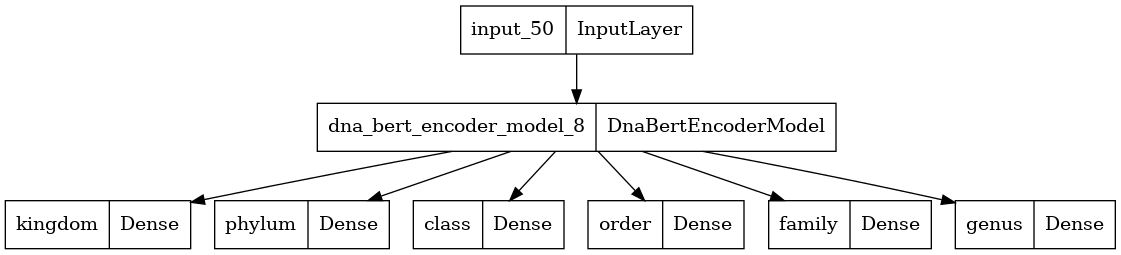

In [195]:
pretrain_model.set_weights(dnabert_weights)

encoder = DnaBertEncoderModel(pretrain_model.base, chunk_size=256)

model = NaiveTaxonomyClassificationModel(encoder, hierarchy)
model.compile()
tf.keras.utils.plot_model(model.model, to_file="/tmp/model.png")

In [ ]:
model.compile()

In [88]:
model.fit(train_dataset)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [27]:
class BertaxTaxonomyClassificationModel(AbstractTaxonomyClassifierModel):
    def __init__(
        self,
        hierarchy: taxonomy.TaxonomyHierarchy,
        include_missing: bool = True,
        **kwargs
    ):
        super().__init__(hierarchy, include_missing, **kwargs)
        self.dense_layers = [
            tf.keras.layers.Dense(c + int(self.include_missing), activation="softmax", name=name.lower())
            for name, c in zip(taxonomy.RANKS, self.hierarchy.taxon_counts)]

    def call(self, inputs, training=None):
        prev = inputs
        out_layer = []
        for dense in self.dense_layers:
            out = dense(prev)
            out_layer.append(out)
            in_help = out_layer.copy()
            in_help.append(prev)
            prev = tf.keras.layers.Concatenate()(in_help)
        return tuple(out_layer)

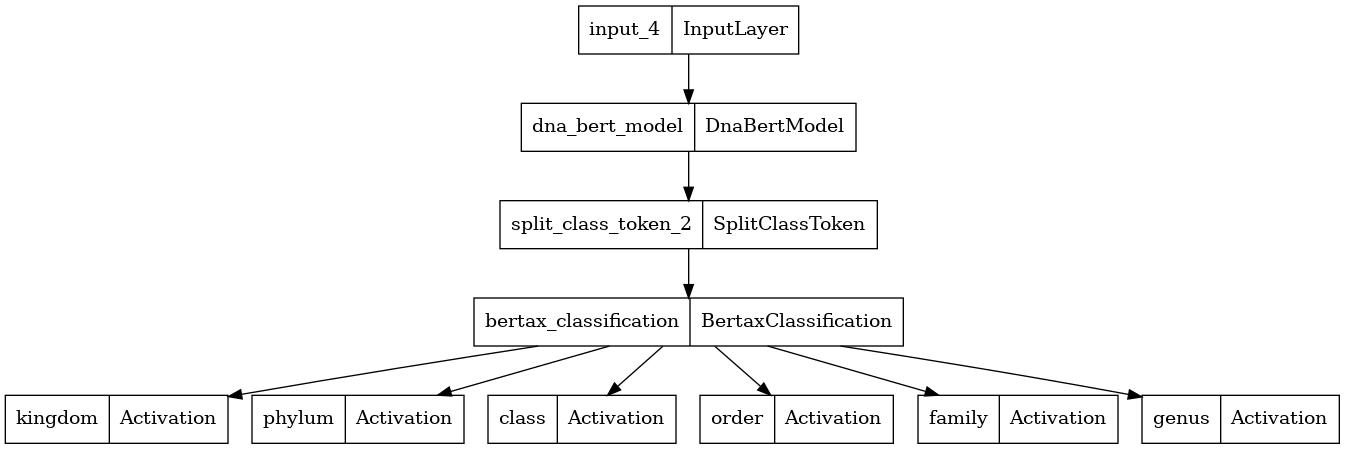

In [25]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
# prev = y
# out_layer = []
# for i in range(hierarchy.depth):
#     rank = taxonomy.RANKS[i].lower()
#     out = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + int(INCLUDE_MISSING), activation="softmax", name=rank)(prev)
#     out_layer.append(out)
#     in_help = out_layer.copy()
#     in_help.append(prev)
#     prev = tf.keras.layers.Concatenate()(in_help)
out_layer = BertaxClassification(hierarchy)(y)
model = tf.keras.Model(x, out_layer)
# model = BertaxModel()
model.compile(
    loss=SparseCategoricalCrossentropyWithIgnoreClass(ignore_class=None if INCLUDE_MISSING else -1),
    metrics=[
        SparseCategoricalAccuracyWithIgnoreClass(ignore_class=None if INCLUDE_MISSING else -1)
    ],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png", expand_nested=True)


In [127]:
x1 = tf.keras.layers.Input((16))
x2 = tf.keras.layers.Input((16))
y = tf.keras.layers.Concatenate()([x1, x2])
y = tf.keras.layers.Dense(16)(y)
model = tf.keras.Model({"x1": x1, "x2": x2}, y)

In [133]:
model.input

{'x1': <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'input_27')>,
 'x2': <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'input_28')>}

In [109]:
model2 = tf.keras.Model(model.input, tf.keras.layers.Dense(1)(model.output))

In [60]:
model2.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 32)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 dense_27 (Dense)               (None, 16)           528         ['concatenate[0][0]']     

In [51]:
model2(tf.random.normal([1, 16]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.8779882]], dtype=float32)>

In [135]:
clone_inputs(model)

ValueError: Unexpectedly found an instance of type `<class 'str'>`. Expected a symbolic tensor instance.